In [1]:
import pandas as pd
import numpy
import nltk
import re
from nltk.corpus import stopwords
from collections import defaultdict 
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [60]:
df = pd.read_csv('AIT722-data.csv')

In [5]:
df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'flag', 'review_id', 'user_id',
       'stars_y', 'useful', 'funny', 'cool', 'text', 'date',
       'user-reviewCount', 'business-reviewCount'],
      dtype='object')

In [10]:
food = ['chicken','sauce','drink','cheese','burger','salad','meat','rice','dessert','pizza','beef','steak','sushi','bread',
       'soup','pork','egg','shrimp','sandwich','potato','buffet','beer','cake','appetizer','chocolate','ramen','green',
       'coffee','crab','onion','taco','garlic','thai','bacon','rib','wine','chip','bbq','tomato','bean','salmon',
       'mushroom','butter','lobster','seafood','corn','pepper','pancake','pasta','veggie','tuna','korean','mac','n','cocktail',
       'sausage','waffle','salt','asian','oyster','salsa','ingredient','eye','truffle','lemon','pie','chinese','vegan',
       'strawberry','shake','chili','tofu','duck','avocado','banana','lettuce','vegetable','calamari','bake','spinach','crepe',
       'pastry','filet','scallop','bone','fruit','meatball','juice','tempura','cheesecake','apple','mango','orange','coconut',
       'pickle','gravy','hawaiian','brisket','caesar','vegetarian','tortilla','sashimi','pudding','margarita','cucumber',
       'vanilla','tacos','basil','patty','sprout','mayo','soda','guacamole','peanut','latte','lime','syrup','paemesan','vietnamese',
       'ranch','ribeye','octopus','ginger','pineapple','cinnamon','katsu','japanese','milk','burrito','donut','american', 'savory']

In [11]:
features = ['chicken','drink','cheese','burger','pizza','coffee','chocolate','wine','veggie','vegetarian','cake','rice','meat',
           'steak','bread','pork','appetizer']

In [12]:
food.extend(['beverage','lemonade','mimosa','beverage','manchego','bleu','hamburger','cheeseburger','pepperoni',
                    'espresso','cappucino','caramel','marshmallow','buterscotch','toffee','riesling','champagne','cabernet',
                   'mushroom','buttercream','mousse','fillet','sourdough','baguette','garlic','chasu'])

In [13]:
dfPreprocessed = pd.read_csv('data1.csv')

In [15]:
dfPreprocessed.head()

,Unnamed: 0,Unnamed: 0.1,useful,stars_y,text,date,user-reviewCount,length,days,readability,newText,newText1,Topics,positive,negative,compound
0,0,0,1,5.0,"['go', 'church', 'breakfast', 'grizz', 'say', ...",2015-05-03,54,180,2041,6.41,"['go', 'church', 'breakfast', 'grizz', 'say', ...",go church breakfast grizz say food good handma...,1,0.388,0.000,0.9905
1,1,1,0,3.0,"['average', 'lot', 'lobster', 'mostly', 'bread...",2018-01-14,58,21,1054,4.70,"['average', 'lot', 'food', 'mostly', 'food', '...",average lot food mostly food food mismatch ok,2,0.239,0.000,0.2960
2,2,2,4,3.0,"['post', 'movie', 'amc', 'gf', 'daughter', 'hu...",2013-07-03,293,403,2710,150.38,"['post', 'movie', 'amc', 'gf', 'daughter', 'hu...",post movie amc gf daughter hungry hour pick da...,1,0.134,0.038,0.9538
3,3,3,6,4.0,"['review', 'tavern', 'part', 'small', 'kinda',...",2015-10-19,345,78,1872,5.02,"['review', 'tavern', 'part', 'small', 'kinda',...",review tavern part small kinda dive money play...,0,0.250,0.149,0.5478
4,4,4,0,5.0,"['france', 'many', 'greek', 'live', 'tell', 'r...",2017-08-06,140,58,1215,15.30,"['france', 'many', 'greek', 'live', 'tell', 'r...",france many greek live tell real greek amazing...,1,0.518,0.075,0.9716


In [16]:
# Total 158 features are extracted
len(food)

158

In [76]:
# Binarize the number of words selected from finalFeatures where 1 word exist 0 not exists
def binarize(finalFeatures, text):
    binaryText = []
    for item in finalFeatures:
        if item in text:
            binaryText.append(1)
        else:
            binaryText.append(0)
    return binaryText

In [77]:
text = dfPreprocessed['text']

In [78]:
text

0        ['go', 'church', 'breakfast', 'grizz', 'say', ...
1        ['average', 'lot', 'lobster', 'mostly', 'bread...
2        ['post', 'movie', 'amc', 'gf', 'daughter', 'hu...
3        ['review', 'tavern', 'part', 'small', 'kinda',...
4        ['france', 'many', 'greek', 'live', 'tell', 'r...
                               ...                        
39995    ['go', 'year', 'ago', 'date', 'get', 'sick', '...
39996    ['total', 'whim', 'decide', 'wanted', 'kalbi',...
39997    ['life', 'hype', 'part', 'order', 'burrota', '...
39998    ['go', 'back', 'sakana', 'second', 'visit', 'g...
39999    ['like', 'place', 'cheap', 'delicious', 'meal'...
Name: text, Length: 40000, dtype: object

In [79]:
text[0]

"['go', 'church', 'breakfast', 'grizz', 'say', 'sausage', 'good', 'handmade', 'site', 'bacon', 'piece', 'huge', 'also', 'include', 'slice', 'ham', 'three', 'egg', 'hash', 'brown', 'cook', 'perfection', 'yum', 'grizz', 'also', 'come', 'sweet', 'cream', 'pancake', 'finish', 'food', 'lot', 'food', 'one', 'person', 'price', 'worth', 'place', 'waaayy', 'well', 'denny', 'ihop', 'best', 'thing', 'love', 'place', 'staff', 'super', 'friendly', 'see', 'jenna', 'try', 'get', 'amazing', 'waitress', 'patient', 'teenager', 'little', 'wishy', 'washy', 'want', 'order', 'family', 'bill', 'include', 'tip', 'impressed', 'teenager', 'full', 'hubby', 'one', 'bring', 'home', 'leftover', 'back', 'thank', 'black', 'bear', 'diner', 'tropicana']"

In [80]:
binaryText = text.apply(lambda x: binarize(food, x))


In [82]:
# Each record is of size 158
len(sum(list(binaryText[2:3]),[]))

158

In [83]:
dfBinaryText = pd.DataFrame({'review': binaryText})
dfBinaryText.shape

(40000, 1)

In [84]:
dfBinaryText['business'] = df['business_id'] 
dfBinaryText['latitude'] = df['latitude']
dfBinaryText['longitude'] = df['longitude']
dfBinaryText['stars'] = df['stars_x']
dfBinaryText['city'] = df['city']

In [85]:
#Aggregating the records(Reviews) of every restaurant, creating a row for each restaurant
dfAggregate = (dfBinaryText['review'].groupby([dfBinaryText.business,dfBinaryText.latitude, dfBinaryText.longitude,dfBinaryText.stars,dfBinaryText.city]).apply(list)).to_frame().reset_index()
dfAggregate[5:10]

,business,latitude,longitude,stars,city,review
5,-K82LBrI3H0FVuhTbNDpRA,36.042532,-115.152754,3.5,Las Vegas,"[[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
6,-LzUYsR54hd8cCiYXTquRA,36.102723,-115.202594,3.0,Las Vegas,"[[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,..."
7,-WLrZPzjKfrftLWaCi1QZQ,36.114273,-115.132729,4.0,Las Vegas,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
8,-_TSaVr53qiEGqMkwyEMaQ,36.100502,-115.209234,4.0,Las Vegas,"[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,..."
9,-ed0Yc9on37RoIoG2ZgxBA,36.168783,-115.139913,4.0,Las Vegas,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,..."


In [86]:
dfAggregate.shape

(662, 6)

In [88]:
temp = []
for i in range(0,158):
    temp.append(0)
len(temp)

158

In [89]:
def summation(lists,temp):
    sums = temp
    for item in lists:
        zipped_lists = zip(sums, item)
        sums = [x + y for (x, y) in zipped_lists]
    return sums
        

In [90]:
dfsummation = dfAggregate['review'].apply(lambda x:summation(x,temp))

In [97]:
# Each record contains list of list, we are converting that into 1 list. That is combining all the vectors into one vector
dfAggregate1 = pd.DataFrame({'review':dfsummation})
dfAggregate1['business'] = dfAggregate['business']
dfAggregate1['stars'] = dfAggregate['stars']
dfAggregate1['city'] = dfAggregate['city']
dfAggregate1['latitude'] = dfAggregate['latitude']
dfAggregate1['longitude'] = dfAggregate['longitude']
dfAggregate = dfAggregate1

In [98]:
dfAggregate

,review,business,stars,city,latitude,longitude
0,"[3, 7, 7, 11, 5, 13, 11, 9, 13, 0, 3, 31, 0, 1...",--9e1ONYQuAa-CB_Rrw7Tw,4.0,Las Vegas,36.123183,-115.169190
1,"[0, 0, 12, 2, 0, 0, 0, 9, 7, 0, 0, 0, 0, 0, 0,...",-95mbLJsa0CxXhpaNL4LvA,4.0,Las Vegas,36.055251,-115.225806
2,"[10, 5, 8, 14, 39, 2, 6, 16, 0, 0, 4, 0, 0, 0,...",-AD5PiuJHgdUcAK-Vxao2A,3.5,Las Vegas,36.103829,-115.137341
3,"[12, 4, 3, 0, 0, 7, 2, 11, 0, 0, 1, 0, 4, 0, 5...",-ADtl9bLp8wNqYX1k3KuxA,4.0,Las Vegas,36.271497,-115.267598
4,"[3, 14, 2, 1, 0, 2, 18, 23, 0, 0, 13, 7, 0, 6,...",-IWsoxH7mLJTTpU5MmWY4w,4.0,Las Vegas,36.126598,-115.197784
...,...,...,...,...,...,...
657,"[15, 6, 5, 6, 1, 32, 3, 7, 12, 0, 0, 1, 0, 14,...",zXBrfL_ohYMuBZWvF8EcSA,3.5,Las Vegas,36.195683,-115.257726
658,"[8, 49, 11, 0, 0, 0, 12, 31, 1, 0, 0, 0, 0, 0,...",zcScEL0WEdFkROcnz5379g,4.0,Las Vegas,36.117128,-115.208511
659,"[30, 31, 8, 14, 3, 0, 24, 62, 6, 0, 39, 3, 0, ...",zdE82PiD6wquvjYLyhOJNA,4.5,Las Vegas,36.179939,-115.206417
660,"[21, 4, 3, 19, 5, 6, 12, 14, 4, 0, 10, 2, 0, 2...",zpoZ6WyQUYff18-z4ZU1mA,4.5,Las Vegas,36.159938,-115.147453


In [100]:
def toWord(x,food):
    index = 0
    word = []
    for item in x:
        val = food[index]
        for i in range(0,item):
            word.append(val)
        index = index+1
    print(index)
    return word
                

In [102]:
dfWord = dfAggregate['review'].apply(lambda x: toWord(x,food))

158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158
158


In [103]:
dfWord = pd.DataFrame({'review':dfWord})
dfWord['business'] = dfAggregate['business']

In [105]:
# TF-IDF 
temp = dfWord['review'].apply(lambda x: ' '.join(x))
v = TfidfVectorizer()
x = v.fit_transform(temp)
# converting the data to dataframe
df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
resultTfIDF = pd.concat([dfWord, df1], axis=1)
resultTfIDF[5:10]

,review,business,american,appetizer,apple,asian,avocado,bacon,baguette,bake,...,truffle,tuna,vanilla,vegan,vegetable,vegetarian,veggie,vietnamese,waffle,wine
5,"[chicken, chicken, chicken, chicken, chicken, ...",-K82LBrI3H0FVuhTbNDpRA,0.013500,0.058753,0.000000,0.014664,0.0,0.079363,0.000000,0.000000,...,0.0,0.028543,0.000000,0.000000,0.000000,0.015860,0.000000,0.0,0.00000,0.000000
6,"[chicken, chicken, chicken, chicken, sauce, sa...",-LzUYsR54hd8cCiYXTquRA,0.044026,0.000000,0.015034,0.159405,0.0,0.014378,0.000000,0.014776,...,0.0,0.020685,0.035296,0.000000,0.014751,0.000000,0.037355,0.0,0.00000,0.000000
7,"[chicken, chicken, chicken, chicken, sauce, sa...",-WLrZPzjKfrftLWaCi1QZQ,0.025612,0.000000,0.026238,0.000000,0.0,0.175655,0.000000,0.025788,...,0.0,0.018050,0.030800,0.034768,0.000000,0.000000,0.021731,0.0,0.28264,0.000000
8,"[chicken, chicken, chicken, chicken, chicken, ...",-_TSaVr53qiEGqMkwyEMaQ,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.304941,0.000000,...,0.0,0.052734,0.000000,0.101578,0.000000,0.087905,0.000000,0.0,0.00000,0.000000
9,"[chicken, chicken, chicken, chicken, chicken, ...",-ed0Yc9on37RoIoG2ZgxBA,0.037713,0.045955,0.000000,0.016386,0.0,0.007390,0.000000,0.007595,...,0.0,0.021262,0.000000,0.020478,0.030326,0.017722,0.031998,0.0,0.00000,0.014906


In [106]:
resultTfIDF.shape

(662, 154)

In [107]:
resultTfIDF['stars'] = dfAggregate['stars']
resultTfIDF['city'] = dfAggregate['city']
resultTfIDF['latitude'] = dfAggregate['latitude']
resultTfIDF['longitude'] = dfAggregate['longitude']

## Model Tuning

In [108]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import SpectralClustering, KMeans
import networkx as nx
from matplotlib import pyplot as plt
from scipy.sparse.linalg import svds
from kneed import KneeLocator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import collections
from statistics import mean
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score

In [112]:
userdata = pd.read_csv('AIT722-data.csv')

In [127]:
userdata.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'flag', 'review_id', 'user_id',
       'stars_y', 'useful', 'funny', 'cool', 'text', 'date',
       'user-reviewCount', 'business-reviewCount'],
      dtype='object')

In [136]:
userdata = userdata.rename(columns = {'business_id':'business'})

In [142]:
userdata.shape

(40000, 25)

In [113]:
len(set(userdata['user_id']))

1807

In [116]:
# The below method generates user-ratings matrix, performs elbow method and to identify the appropriate number of clusters
# Apply K-Means clustering and label the data
def userRestaurantMatrix(data):
    matrix = pd.pivot_table(data,values='stars_y',index=['user_id'], columns=['business_id'],fill_value = 0)
    new_df = pd.DataFrame(matrix.to_records())
    ID = list(new_df.columns)
    ID.remove('user_id')
    # SVD - Matrix Factorization
    user_ratings_mean = np.mean(matrix, axis = 1)
    R_demeaned = matrix - user_ratings_mean.values.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k = 50)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)
    ###
    new_df = pd.DataFrame(all_user_predicted_ratings, columns = list(new_df.columns)[1:])
    #print(new_df.shape)
    # Pairwise similarity
    similarity = cosine_similarity(new_df.T)
    # K-Means
    #print(np.shape(similarity))
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(similarity)
        sse.append(kmeans.inertia_)
    # Kneed method is used to identify the best number of clusters
    kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
    # We are using elbow method to identify the best number of clusters
    cluster = kl.elbow
    # Clustering our dataset
    kmeans = KMeans(n_clusters=cluster)
    kmeans.fit(similarity[:])
    colors = kmeans.labels_
    print(len(colors))
    return similarity, sse, list(colors), cluster, ID

In [117]:
similarity, sse, color,c1, ID = userRestaurantMatrix(userdata) 

662


In [118]:
c1

4

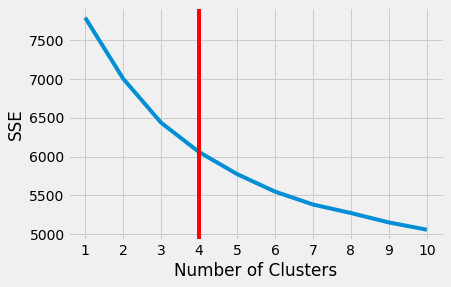

In [121]:
# plot for sse, to identify the appropriate number of clusters
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.axvline(c1,color = 'r')
plt.show()

In [130]:
len(ID)

662

In [180]:
# add label to the data, extract features for each city. We used cross_val_score to find accuracy 
def featureImportance(data,c,ID):
    #data = data.dropna()
    df = pd.DataFrame()
    df['business'] = ID
    df['cluster'] = c
    final_data = pd.merge(data, df.rename(columns={'business':'business'}), on='business',  how='left')
    final_data = final_data.reset_index()
    final_data = final_data.drop('business',1)
    Y = final_data['cluster'] # target column
    X = final_data.drop(columns = ['cluster','review','stars','city','index','latitude','longitude'])  #independent columns
    colu = list(X.columns)
    d = pd.DataFrame()
    d['latitude'] = data['latitude']
    d['longitude'] = data['longitude']
    d['cluster'] = c
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    clf = SGDClassifier(loss='log', penalty='l1', l1_ratio=0.9, learning_rate='optimal', max_iter=10, shuffle=False, n_jobs=3, fit_intercept=True)
    clf.fit(X_train, y_train)
    for i in range(0, clf.coef_.shape[0]):
        top20_indices = np.argsort(clf.coef_[i])[-20:]
        print(top20_indices)
    model = ExtraTreesClassifier()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    # F1 score
    #f1 = accuracy_score(y_test, y_pred)
    f1 = cross_val_score(model, X, Y, cv=5)
    f1 = mean(f1)
    # feature importance
    features = model.feature_importances_
    # list of column names from original data
    cols = X.columns
    # feature importances from random forest fit rf
    # form dictionary of feature ranks and features
    features_dict = dict(zip(np.argsort(features),cols))
    features_dict = sorted(features_dict.items())[:20]
    # Extracting features from list
    feature = []
    for item in features_dict:
        feature.append(item[1])
    # the dictionary key are the importance rank; the values are the feature name
    return f1,feature,d,final_data,colu

In [181]:
from sklearn.linear_model import SGDClassifier
f1,x1,d1,final,colu = featureImportance(resultTfIDF,color,ID)

[108 142  86 138  97  34  19  46   6  87 140 117 100  79  44  43  74 110
  41  25]
[133  82  88 142 119  84  21 118  36  47  51  18 103  94 145  91  70  68
  48 113]
[ 11  79  30  63  10 127  85  56 107 151 115 128 112  47  83   2  16 144
  29  27]
[109  95  50  59  66  97  81  55 139  58 140  32 147  53  11   7 129  78
 135  96]


In [183]:
x = [108, 142, 86,138,97,34, 19,46,6,87,140,117,100,79,44,43,74,110,41,25]
for i in x:
    print(colu[i])

rib
truffle
mousse
toffee
pepper
cheesecake
buffet
crepe
baguette
mushroom
tomato
sashimi
pie
margarita
corn
coffee
lime
rice
cocktail
caesar


In [184]:
#1
x = [133,82,88,142,119,84,21,118,36,47,51,18,103,94,145,91,70,68,48,113]
for i in x:
    print(colu[i])

syrup
meat
octopus
truffle
sausage
milk
burrito
sauce
chili
cucumber
duck
brisket
pork
pastry
vegan
oyster
latte
katsu
dessert
salmon


In [185]:
#2
x = [11,79,30,63,10,127,85,56,107,151,115,128,112,47,83,2,16,144,29,27]
for i in x:
    print(colu[i])

bean
margarita
champagne
hamburger
bbq
sourdough
mimosa
fillet
ranch
wine
salt
spinach
salad
cucumber
meatball
apple
bone
vanilla
caramel
calamari


In [186]:
#3
x = [109,95,50,59,66,97,81,55,139,58,140,32,147,53,11,7,129 ,78,135,96]
for i in x:
    print(colu[i])

ribeye
patty
drink
ginger
japanese
pepper
mayo
filet
tofu
garlic
tomato
cheese
vegetarian
espresso
bean
bake
sprout
mango
tacos
peanut


In [156]:
d1.to_csv('cluster.csv')